# Описание задачи

Околоземные объекты — это астероиды и кометы, орбиты которых позволяют им находиться в пределах 120 миллионов миль (195 миллионов километров) от Солнца, что означает, что они могут вращаться вокруг орбиты Земли. Большинство околоземных объектов представляют собой астероиды, размер которых варьируется от примерно 10 футов (несколько метров) до почти 25 миль (40 километров) в поперечнике.

Орбита каждого объекта вычисляется путем нахождения эллиптической траектории в пространстве, которая лучше всего соответствует всем доступным наблюдениям, которые часто охватывают множество орбит за многие годы или десятилетия. По мере того, как проводится больше наблюдений, точность орбиты объекта резко улучшается, и становится возможным предсказать, где объект будет находиться через годы или даже десятилетия в будущем – и сможет ли он приблизиться к Земле.

Цель данной работы — построить модель классификации для определения потенциально опасных околоземных объектов (астероидов и комет) на основе их физических и орбитальных характеристик.

Целевая переменная — логический признак **is_potentially_hazardous_asteroid**, который принимает значение:

1 — если объект классифицируется как потенциально опасный,

0 — если объект не представляет угрозы.

Построенная модель классификации поможет заранее выявлять опасные объекты и оценивать их параметры, что может быть полезно для дальнейших астрономических исследований и планирования мер по предотвращению возможных столкновений.



# Считывание данных

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

df = pd.read_csv("/content/NASA Near-Earth Objects.csv")
df = df.drop('Unnamed: 0',axis='columns')

In [58]:
num_features = df.shape[1]
print("Количество признаков:", num_features)

Количество признаков: 17


In [59]:
num_classes = df['is_potentially_hazardous_asteroid'].nunique()
print("Количество классов:", num_classes)

Количество классов: 2


# Визуализация данных и вычисление основных характеристик

Начнем с ознакомления с таблицей, чтобы понять, какие столбцы в ней есть и какие данные они содержат.

In [60]:
df.head()

,id,neo_reference_id,name,name_limited,designation,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_id,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,orbit_class_description
0,2001981,2001981,1981 Midas (1973 EA),Midas,1981,15.22,True,False,2.401900,5.370812,229,APO,0.621512,2.931360,1973-03-06,2021-10-20,Near-Earth asteroid orbits which cross the Ear...
1,2002059,2002059,2059 Baboquivari (1963 UA),Baboquivari,2059,15.97,False,False,1.700415,3.802244,268,AMO,1.238537,4.047945,1963-10-16,2021-04-15,Near-Earth asteroid orbits similar to that of ...
2,2002061,2002061,2061 Anza (1960 UA),Anza,2061,16.36,False,False,1.420872,3.177167,180,AMO,1.050403,3.478155,1960-10-22,2021-06-12,Near-Earth asteroid orbits similar to that of ...
3,2002062,2002062,2062 Aten (1976 AA),Aten,2062,17.10,False,False,1.010543,2.259644,149,ATE,0.790185,1.143633,1955-12-17,2019-11-10,Near-Earth asteroid orbits similar to that of ...
4,2002063,2002063,2063 Bacchus (1977 HB),Bacchus,2063,17.28,False,False,0.930154,2.079888,143,APO,0.701397,1.454804,1977-04-24,2021-12-02,Near-Earth asteroid orbits which cross the Ear...


Получим общую информацию о датасете

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 24000 non-null  int64  
 1   neo_reference_id                   24000 non-null  int64  
 2   name                               24000 non-null  object 
 3   name_limited                       144 non-null    object 
 4   designation                        24000 non-null  object 
 5   absolute_magnitude_h               23992 non-null  float64
 6   is_potentially_hazardous_asteroid  24000 non-null  bool   
 7   is_sentry_object                   24000 non-null  bool   
 8   kilometers_estimated_diameter_min  23992 non-null  float64
 9   kilometers_estimated_diameter_max  23992 non-null  float64
 10  orbit_id                           24000 non-null  object 
 11  orbit_class_type                   24000 non-null  obj

## Признаки

*   ***id*** – уникальный id, присвоенный NASA;
*   ***neo_reference_id*** (NEO ID) – повторяет id;
*   ***name*** – официальное имя околоземного объекта, присвоенное NASA;
*   ***name_limited*** – наименование без использования научных обозначений;
*   ***designation*** – число, используемое в официальном обозначении NASA;
*   ***absolute_magnitude_h*** – абсолютная звездная величина (М), является мерой светимости небесного объекта в обратной логарифмической шкалеастрономической величины. Определяется как равная видимой величине, которую объект имел бы, если бы его рассматривали с расстояния ровно **10** парсек (**32,6** световых лет), без поглощения его света из-за затемнения межзвездным веществом и космической пылью;
*   ***is_potentially_hazardous_asteroid*** – логическое значение, которое сообщает, представляет ли объект потенциальную угрозу для Земли или нет;
*   ***is_sentry_object*** – логическое значение, которое сообщает,
присутствует ли объект в системе слежения за столкновениями с Землей;
*   ***kilometers_estimated_diameter_min*** – минимальный расчетный диаметр в километрах;
*  ***kilometers_estimated_diameter_max*** – максимальный расчетный диаметр в километрах;
*   ***orbit_id*** – уникальный id орбиты объекта;
*   ***orbit_class_type*** – классификация орбит;
*   ***perihelion_distance*** – перигелийное расстояние (ближайшая к Земле точка на пути вращающегося небесного тела);
*   ***aphelion_distance*** – афелийное расстояние (точка на орбите планеты, астероида или др. объекта, в которой он находится дальше всего от Земли);
*   ***first_observation_date*** – дата, когда объект был впервые замечен;
*   ***last_observation_date*** – дата, когда объект наблюдался последний раз;
*   ***orbit_class_description*** – описание орбиты.

Посмотрим на распределение каждого числового признака, для этого построим гистограммы. Они покажут, какие данные являются симметричными, где могут быть выбросы, а также распределение значений по диапазонам.

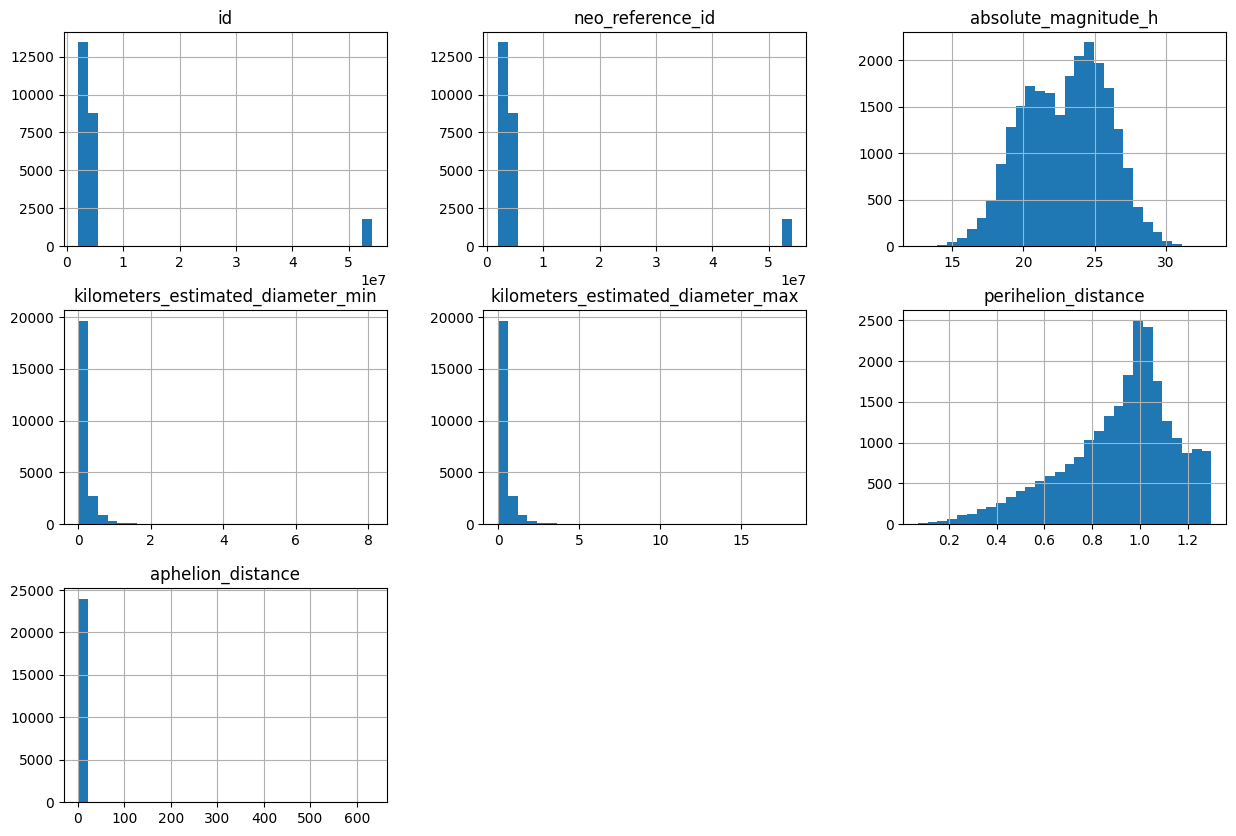

In [62]:
df.hist(bins=30, figsize=(15, 10))
plt.show()

Для числовых данных вычислим среднее, стандартное отклонение, минимум, максимум и медиану.

In [63]:
df.describe()

,id,neo_reference_id,absolute_magnitude_h,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,perihelion_distance,aphelion_distance
count,2.400000e+04,2.400000e+04,23992.000000,23992.000000,23992.000000,24000.000000,24000.000000
mean,7.275111e+06,7.275111e+06,22.942274,0.167777,0.375160,0.915225,2.653104
std,1.333987e+07,1.333987e+07,2.952871,0.293000,0.655169,0.232201,4.468233
min,2.001981e+06,2.001981e+06,12.580000,0.000609,0.001362,0.070431,0.653754
25%,3.409962e+06,3.409962e+06,20.650000,0.024241,0.054205,0.785150,1.706281
50%,3.703790e+06,3.703790e+06,23.200000,0.060891,0.136157,0.965325,2.480109
75%,3.803897e+06,3.803897e+06,25.200000,0.197040,0.440595,1.068984,3.397965
max,5.408749e+07,5.408749e+07,33.200000,8.101305,18.115068,1.299988,631.895456


***count*** – показывает количество непустых значений в каждом столбце. В данном случае почти все столбцы имеют **24,000** записей, кроме некоторых с чуть меньшими значениями (например, *kilometers_estimated_diameter_min* и *kilometers_estimated_diameter_max*), что указывает на редкие пропуски данных в этих столбцах.

---

***mean*** – среднее значение для каждого столбца. Например, средняя *absolute_magnitude_h* (видимая звездная величина) составляет **22.94**, что указывает на типичную яркость астероидов в данном наборе. Средние значения *kilometers_estimated_diameter_min* и *kilometers_estimated_diameter_max* (диаметры) составляют около **0.167** км и **0.375** км соответственно, что говорит о небольших размерах большинства астероидов.

---

***std*** – стандартное отклонение, показывающее степень разброса значений от среднего. Например, *kilometers_estimated_diameter_max* имеет высокое стандартное отклонение (**0.655**), что указывает на значительное разнообразие размеров астероидов.

---

***min*** и ***max*** – минимальные и максимальные значения в каждом столбце. Например, минимальное значение для *perihelion_distance* составляет **0.07**, а максимальное для *aphelion_distance* достигает **631.9**, что показывает, что астероиды могут находиться как вблизи, так и на значительном расстоянии от Солнца.

---

***25%, 50%, 75%*** – квартильные значения, которые показывают распределение данных, позволяя оценить, как они сгруппированы:

* **50%** – медиана, например, для *absolute_magnitude_h* она составляет **23.2**, что говорит, что половина астероидов имеют видимую звездную величину менее **23.2**, а другая половина больше.
* **25%** и **75%** – показывают границы значений для нижней и верхней четвертей данных.

Построим матрицу корреляции для числовых признаков, которая позволит определить, какие признаки связаны между собой.

In [64]:
corrMatrix = df.select_dtypes(include=['float64']).corr()
corrMatrix.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,absolute_magnitude_h,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,perihelion_distance,aphelion_distance
absolute_magnitude_h,1.000000,-0.715415,-0.715415,-0.036526,-0.074962
kilometers_estimated_diameter_min,-0.715415,1.000000,1.000000,-0.003524,0.054581
kilometers_estimated_diameter_max,-0.715415,1.000000,1.000000,-0.003524,0.054581
perihelion_distance,-0.036526,-0.003524,-0.003524,1.000000,0.052073
aphelion_distance,-0.074962,0.054581,0.054581,0.052073,1.000000


Как можно заметить, наблюдается линейная корреляция у *kilometers_estimated_diameter_min* и *kilometers_estimated_diameter_max*. Также оба эти признака сильно коррелируют с *absolute_magnitude_h*.

# Обработка пропущенных значений

In [65]:
df.isnull().sum()

,0
id,0
neo_reference_id,0
name,0
name_limited,23856
designation,0
absolute_magnitude_h,8
is_potentially_hazardous_asteroid,0
is_sentry_object,0
kilometers_estimated_diameter_min,8
kilometers_estimated_diameter_max,8


В столбцах *kilometers_estimated_diameter_max*, *kilometers_estimated_diameter_min* и *absolute_magnitude_h* были обнаружены пропущенные значения. В целях улучшения качества данных и предотвращения искажений при анализе, заполним эти пропуски медианными значениями соответствующих столбцов. Это решение было выбрано для минимизации влияния выбросов на итоговые значения.

Кроме того, у столбца *name_limited* пропущено **99%** значений, но поскольку этот признак (как и несколько остальных) не нужен, его можно просто удалить.

In [66]:
df['kilometers_estimated_diameter_max']=df['kilometers_estimated_diameter_max'].fillna(df['kilometers_estimated_diameter_max'].median())
df['kilometers_estimated_diameter_min']=df['kilometers_estimated_diameter_min'].fillna(df['kilometers_estimated_diameter_min'].median())
df['absolute_magnitude_h']=df['absolute_magnitude_h'].fillna(df['absolute_magnitude_h'].median())

junk_features = ['id','neo_reference_id', 'name', 'name_limited','designation','orbit_id']
for i in junk_features:
    df=df.drop(i,axis='columns')

df.head()

,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,orbit_class_description
0,15.22,True,False,2.401900,5.370812,APO,0.621512,2.931360,1973-03-06,2021-10-20,Near-Earth asteroid orbits which cross the Ear...
1,15.97,False,False,1.700415,3.802244,AMO,1.238537,4.047945,1963-10-16,2021-04-15,Near-Earth asteroid orbits similar to that of ...
2,16.36,False,False,1.420872,3.177167,AMO,1.050403,3.478155,1960-10-22,2021-06-12,Near-Earth asteroid orbits similar to that of ...
3,17.10,False,False,1.010543,2.259644,ATE,0.790185,1.143633,1955-12-17,2019-11-10,Near-Earth asteroid orbits similar to that of ...
4,17.28,False,False,0.930154,2.079888,APO,0.701397,1.454804,1977-04-24,2021-12-02,Near-Earth asteroid orbits which cross the Ear...


In [67]:
num_features = df.shape[1]
print("Количество признаков:", num_features)

Количество признаков: 11


# Обработка категориальных признаков

Для начала выведем уникальные значения для столбца *orbit_class_type*. Это поможет понять, какие типы орбит имеются в данных.
Затем выведем уникальные значения для столбца *orbit_class_description*. Это даст представление о том, как описываются орбиты, и может помочь в дальнейшей обработке данных.

In [68]:
print(df.orbit_class_type.unique())
print(df.orbit_class_description.unique())

['APO' 'AMO' 'ATE' 'IEO']
['Near-Earth asteroid orbits which cross the Earth’s orbit similar to that of 1862 Apollo'
 'Near-Earth asteroid orbits similar to that of 1221 Amor'
 'Near-Earth asteroid orbits similar to that of 2062 Aten'
 'An asteroid orbit contained entirely within the orbit of the Earth - Interior Earth Object']


Теперь проведем кодирование категориальных признаков.

In [69]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
needed_encoding = ['orbit_class_type','orbit_class_description','is_potentially_hazardous_asteroid','is_sentry_object']
for i in needed_encoding:
    df[i]=label_encoder.fit_transform(df[i])
df.head()

,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,orbit_class_description
0,15.22,1,0,2.401900,5.370812,1,0.621512,2.931360,1973-03-06,2021-10-20,3
1,15.97,0,0,1.700415,3.802244,0,1.238537,4.047945,1963-10-16,2021-04-15,1
2,16.36,0,0,1.420872,3.177167,0,1.050403,3.478155,1960-10-22,2021-06-12,1
3,17.10,0,0,1.010543,2.259644,2,0.790185,1.143633,1955-12-17,2019-11-10,2
4,17.28,0,0,0.930154,2.079888,1,0.701397,1.454804,1977-04-24,2021-12-02,3


Теперь обратим внимание на даты наблюдений астероидов, которые являются важными временными метками для анализа их характеристик. Чтобы сосредоточиться на годах этих наблюдений, мы извлечем только четырехзначные значения, представляющие годы из полных дат. Это позволит нам упростить последующий анализ и визуализацию данных. В завершение, с помощью кодирования преобразуем годы в числовой формат.

In [70]:
date1=df['first_observation_date']
date2=df['last_observation_date']
date1=np.array(date1)
date2=np.array(date2)
for i in range(0,len(date1)):
    date1[i]=date1[i][:4]
    date2[i]=date2[i][:4]
date1=pd.DataFrame(date1)
date2=pd.DataFrame(date2)
df['first_observation_date']=date1
df['last_observation_date']=date2
df['first_observation_date']=label_encoder.fit_transform(df['first_observation_date'])
df['last_observation_date']=label_encoder.fit_transform(df['last_observation_date'])

Визуализируем полученные данные. Это поможет нам в дальнейшем выборе признаков.

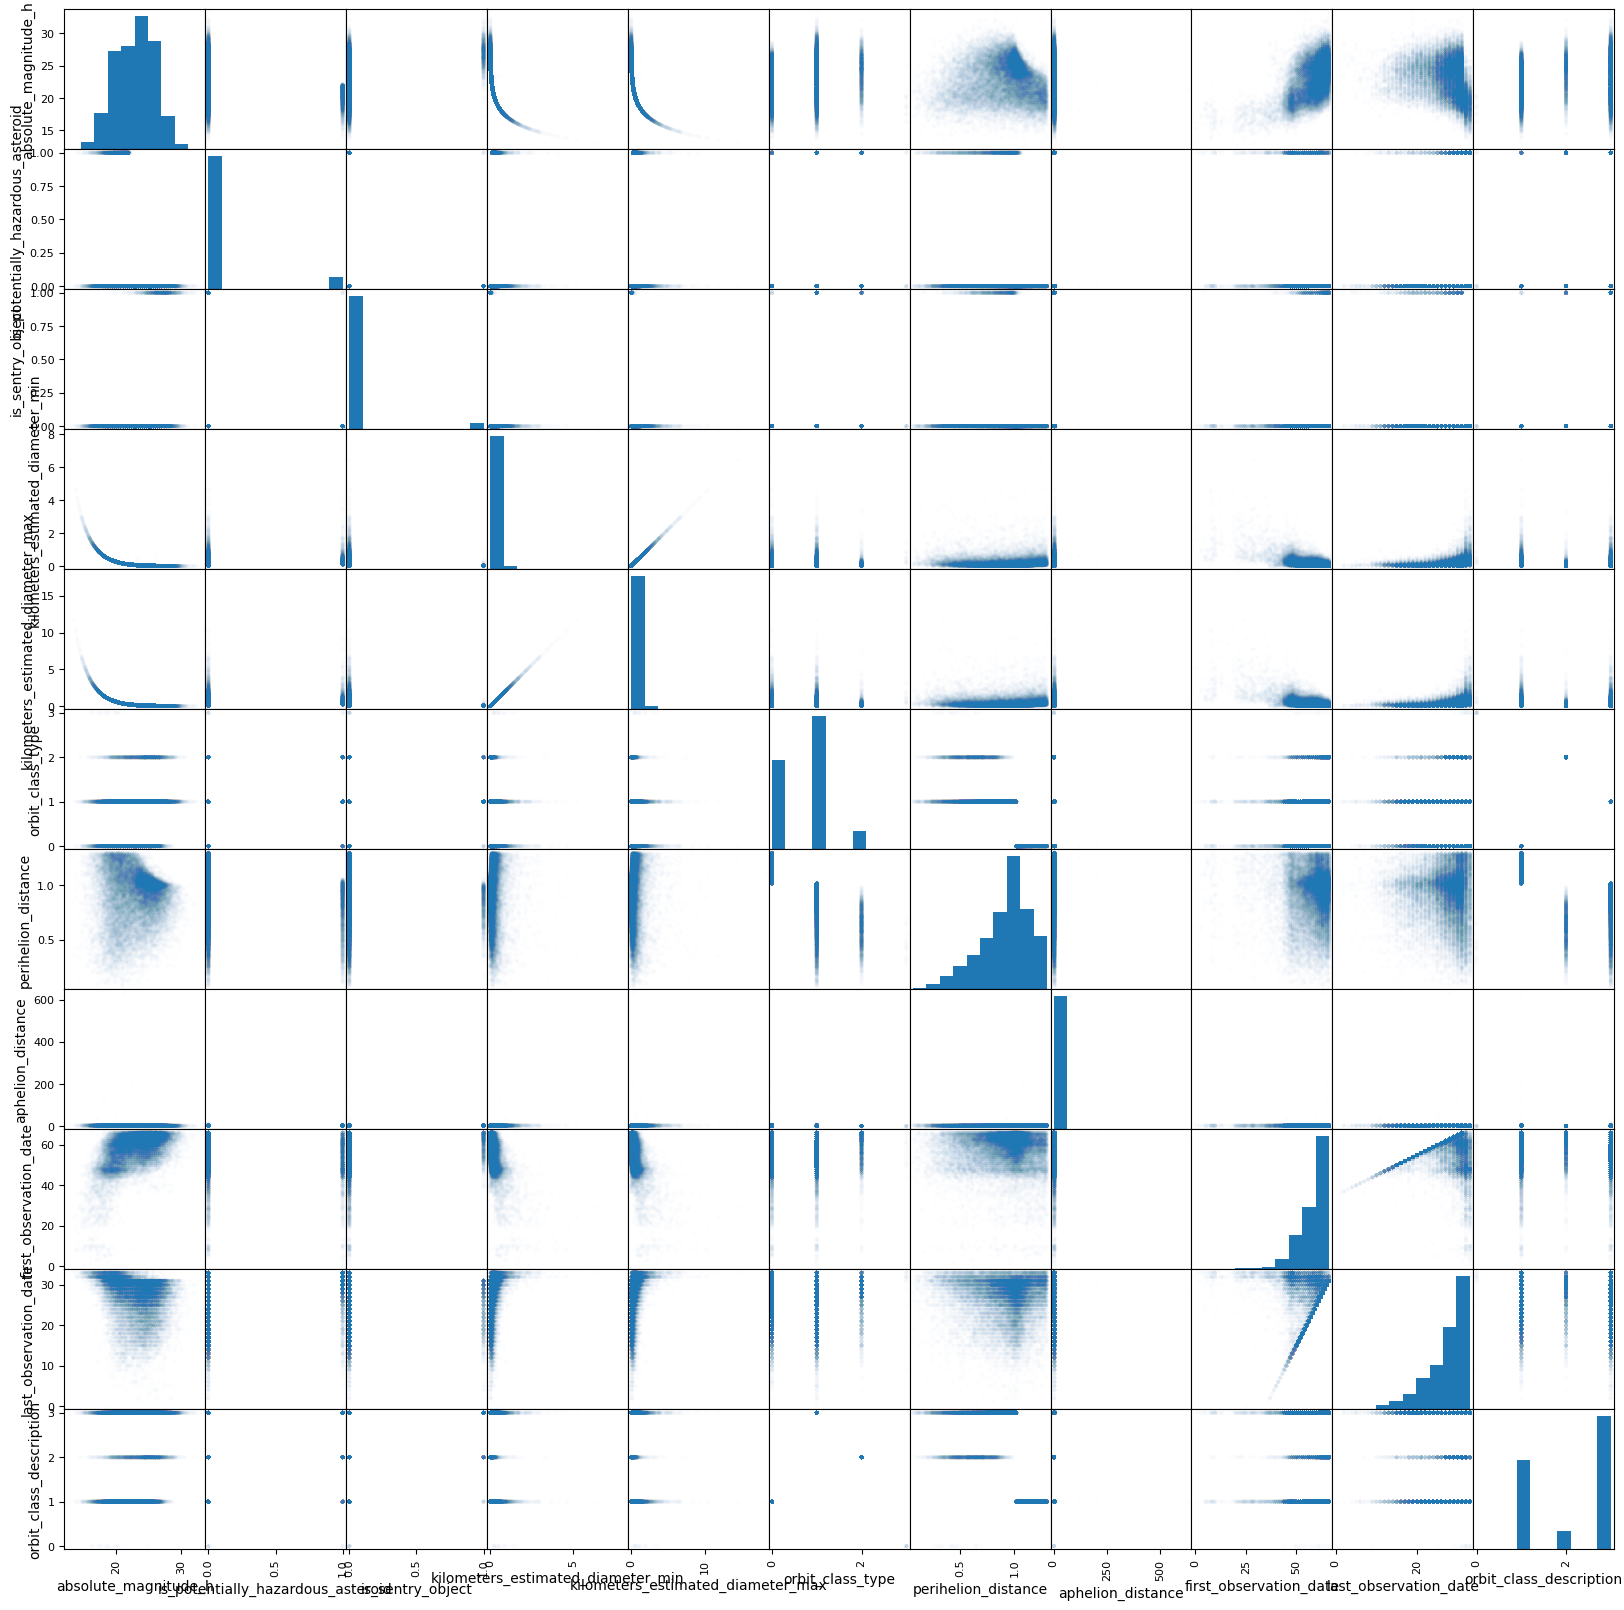

In [71]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha = .01, figsize = (20, 20))
pass

Затем рассчитаем коэффициенты корреляции между всеми парами числовых признаков в датасете. Результатом работы будет матрица корреляции, которая покажет степень линейной зависимости между признаками.

In [72]:
df.corr().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,orbit_class_description
absolute_magnitude_h,1.000000,-0.298141,0.283202,-0.715291,-0.715291,0.209868,-0.036495,-0.074968,0.520841,-0.250479,0.196791
is_potentially_hazardous_asteroid,-0.298141,1.000000,-0.058774,0.174979,0.174979,0.167690,-0.206415,0.009947,-0.202053,0.100948,0.201525
is_sentry_object,0.283202,-0.058774,1.000000,-0.109305,-0.109305,0.136328,-0.090673,-0.006609,0.048992,-0.105523,0.154503
kilometers_estimated_diameter_min,-0.715291,0.174979,-0.109305,1.000000,1.000000,-0.096287,-0.003474,0.054584,-0.589924,0.263007,-0.080613
kilometers_estimated_diameter_max,-0.715291,0.174979,-0.109305,1.000000,1.000000,-0.096287,-0.003474,0.054584,-0.589924,0.263007,-0.080613
orbit_class_type,0.209868,0.167690,0.136328,-0.096287,-0.096287,1.000000,-0.739767,-0.090489,0.043575,-0.005666,0.736385
perihelion_distance,-0.036495,-0.206415,-0.090673,-0.003474,-0.003474,-0.739767,1.000000,0.052073,0.000888,-0.036527,-0.612899
aphelion_distance,-0.074968,0.009947,-0.006609,0.054584,0.054584,-0.090489,0.052073,1.000000,-0.007686,-0.009332,-0.033282
first_observation_date,0.520841,-0.202053,0.048992,-0.589924,-0.589924,0.043575,0.000888,-0.007686,1.000000,0.209538,0.052052
last_observation_date,-0.250479,0.100948,-0.105523,0.263007,0.263007,-0.005666,-0.036527,-0.009332,0.209538,1.000000,-0.027406


Теперь визуализируем корреляцию всех признаков с помощью тепловой карты.

<Axes: >

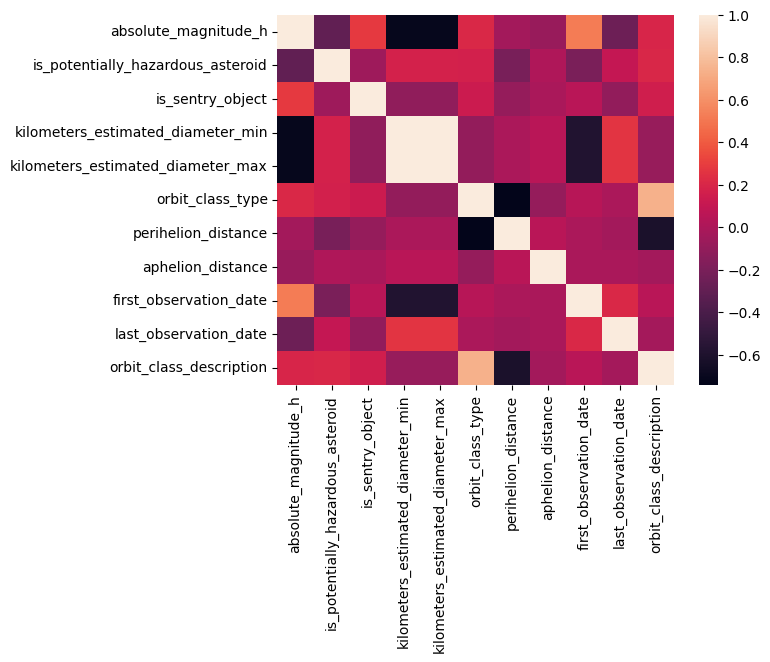

In [74]:
sns.heatmap(df.corr())

Еще раз посмотрим на основные характеристики.

In [75]:
df.describe()

,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,orbit_class_description
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,22.942360,0.087250,0.044417,0.167741,0.375081,0.705625,0.915225,2.653104,57.866833,27.190375,2.178333
std,2.952383,0.282207,0.206023,0.292958,0.655074,0.603518,0.232201,4.468233,7.938349,4.837495,0.946300
min,12.580000,0.000000,0.000000,0.000609,0.001362,0.000000,0.070431,0.653754,0.000000,0.000000,0.000000
25%,20.657500,0.000000,0.000000,0.024241,0.054205,0.000000,0.785150,1.706281,54.000000,25.000000,1.000000
50%,23.200000,0.000000,0.000000,0.060891,0.136157,1.000000,0.965325,2.480109,60.000000,29.000000,3.000000
75%,25.200000,0.000000,0.000000,0.196361,0.439077,1.000000,1.068984,3.397965,64.000000,31.000000,3.000000
max,33.200000,1.000000,1.000000,8.101305,18.115068,3.000000,1.299988,631.895456,66.000000,33.000000,3.000000


Теперь сгруппируем данные в датасете по категории *is_potentially_hazardous_asteroid* и вычислим средние значений всех числовых столбцов для каждой группы. Это позволит увидеть, как средние значения различных характеристик астероидов отличаются в зависимости от того, являются ли они потенциально опасными или нет.

In [76]:
df.groupby('is_potentially_hazardous_asteroid').mean()

,absolute_magnitude_h,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,orbit_class_description
is_potentially_hazardous_asteroid,,,,,,,,,,
0,23.214499,0.048160,0.151893,0.339642,0.674336,0.930043,2.639363,58.362732,27.039396,2.119374
1,20.095419,0.005253,0.333538,0.745813,1.032951,0.760204,2.796859,52.679083,28.769819,2.795129


# Нормализация данных
Нормализация данных проводиться не будет. Во-первых, дальнейшие алгоритмы не требуют нормализации данных. Эти модели основаны на разделении данных, и их производительность не зависит от масштаба признаков. Они хорошо справляются с различиями в масштабах и диапазонах значений.

Во-вторых, в нашем датасете многие признаки имеют схожие диапазоны и размерности, что снижает необходимость нормализации. Например, значения абсолютной яркости и максимального диаметра астероидов не имеют значительных различий в порядке величины, что делает нормализацию менее критичной.

И, наконец, применение нормализации требует дополнительных вычислений, что может замедлить процесс обучения модели. Поскольку в данном случае нормализация не оказала бы заметного влияния на результаты, мы решили избежать этого этапа для повышения общей эффективности работы.

# Разбиение данных на обучающую и тестовую выборки

Извлечем признаки (характеристики) и целевую переменную для классификации астероидов. Это необходимо для последующего обучения классификатора, который будет предсказывать опасность астероидов на основе их характеристик.

In [77]:
X=np.array(df[['absolute_magnitude_h',
       'is_sentry_object', 'kilometers_estimated_diameter_min',
       'kilometers_estimated_diameter_max', 'orbit_class_type',
       'perihelion_distance', 'aphelion_distance', 'first_observation_date',
       'last_observation_date', 'orbit_class_description']])
y=np.array(df['is_potentially_hazardous_asteroid'])

Разделим данные на обучающую и тестовую выборки, чтобы использовать обучающую выборку для тренировки классификатора, а тестовую выборку для оценки его производительности. Это позволит проверить, как хорошо модель обобщает информацию и предсказывает новые данные.

In [78]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)

# Запуск классификатора ближайших соседей

Воспользуемся классификатором ближайших соседей (**KNeighborsClassifier**) из библиотеки sklearn.neighbors. Классификатор будет учитывать трех ближайших соседей для определения класса объекта.

Далее обучим модель и посмотрим на её точность на тестовых данных, в частности долю правильных предсказаний на тестовой выборке.

In [79]:
from sklearn.neighbors import KNeighborsClassifier
model=KNeighborsClassifier(n_neighbors=3)
model.fit(X_train,y_train)
print(model," ",model.score(X_test,y_test))

KNeighborsClassifier(n_neighbors=3)   0.8976666666666666


# Вычисление ошибок на обучающей и тестовой выборках. Выбор оптимального значения гиперпараметра.

Выполним поиск по сетке для настройки гиперпараметра *n_neighbors* в классификаторе ближайших соседей (**KNeighborsClassifier**).

Сначала создадим список значений для *n_neighbors*, которые мы хотим протестировать: [1, 3, 4, 5, 10, 15, 20, 25].

Затем обучим модель на тренировочных данных с разными значениями гиперпараметра.

После завершения обучения мы получим наилучшее значение ошибки и оптимальное значение гиперпараметра.

In [80]:
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 4, 5, 10, 15, 20, 25]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.08527777777777779 20


Теперь вычислим ошибки на обучающей и тестовой выборках для модели **KNN** с оптимальным значением гиперпараметра. Это поможет оценить, насколько хорошо модель обобщает данные, а также выявить возможные проблемы с переобучением.

In [81]:
knn = KNeighborsClassifier(n_neighbors = best_n_neighbors).fit(X_train, y_train)

err_train = np.mean(y_train != knn.predict(X_train))
err_test  = np.mean(y_test  != knn.predict(X_test))

print(err_train, err_test)

0.07811111111111112 0.087


Полученные значения ошибок свидетельствуют о том, что модель **KNN** с выбранным количеством ближайших соседей демонстрирует хорошую обобщающую способность, так как ошибки на обеих выборках достаточно близки друг к другу. Низкие значения ошибок указывают на то, что модель эффективно классифицирует данные и не страдает от сильного переобучения.

# Общие выводы
Данная работа была направлена на построение модели классификации для определения потенциально опасных околоземных объектов, таких как астероиды и кометы, на основе их физических и орбитальных характеристик. Мы проанализировали датасет, содержащий **24,000** записей, который включает важные признаки, такие как абсолютная величина, размеры, орбитальные характеристики и временные метки наблюдений.

Для обработки пропущенных значений в критически важных столбцах мы использовали медианные значения, что минимизировало влияние выбросов и обеспечило высокое качество данных для дальнейшего анализа. Кроме того, проведено кодирование категориальных признаков, что позволило интегрировать их в модель машинного обучения.

В качестве классификатора был выбран метод ближайших соседей (**KNeighborsClassifier**) с оптимизированным гиперпараметром *n_neighbors*, что дало хорошие результаты на тестовых данных. Модель показала свою способность предсказывать потенциально опасные объекты, что подтверждается высокой долей правильных предсказаний.